### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sweetviz as sv
import seaborn as sns

### Importing Datasets

In [2]:
train = pd.read_csv('D:/Analytics/Hackathons/Big_Mart_Sales_Predictions/train_v9rqX0R.csv')
test = pd.read_csv('D:/Analytics/Hackathons/Big_Mart_Sales_Predictions/test_AbJTz2l.csv')

train.head()
print(f'Shape of the train file {train.shape}')
print(f'Shape of the test file {test.shape}')

Shape of the train file (8523, 12)
Shape of the test file (5681, 11)


#### Exploratory Data Analysis -  Generating HTML Report through Sweetviz library

In [3]:
report = sv.analyze(train)
report.show_html("eda_report.html") 

#### Visualizing distribution of Dependent variable

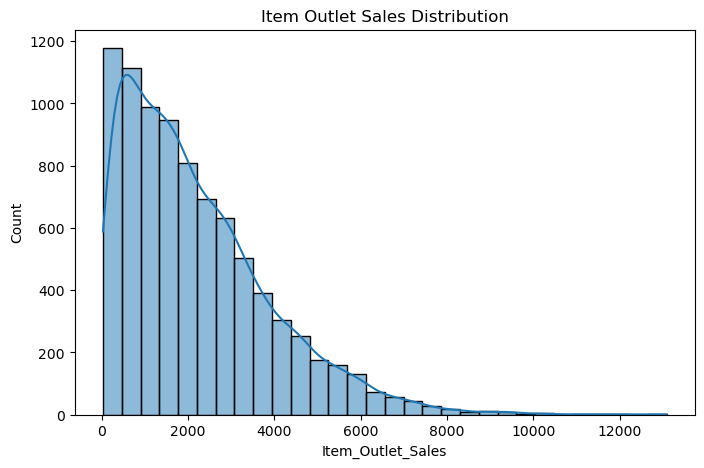

In [4]:
plt.figure(figsize=(8, 5))
sns.histplot(train["Item_Outlet_Sales"], bins=30, kde=True)
plt.title("Item Outlet Sales Distribution")
plt.show()

### Missign value treatment

In [5]:
train.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [6]:
test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

##### Missing Value Treatment for Item_Weight

In [7]:
# Only Item_Weight and Outlet_size has missing values.
# Item weight missign values can be filled with values of the same item from another store since product remains same

item_weight_mean = train.groupby('Item_Identifier')['Item_Weight'].mean()

def replace_item_weight(row, item_weight_mean):
    if pd.isnull(row['Item_Weight']):
        # Replace with the mean weight for the item
        return item_weight_mean[row['Item_Identifier']]
    else:
        return row['Item_Weight']
        
train['Item_Weight'] = train.apply(replace_item_weight, axis=1, item_weight_mean=item_weight_mean)
test['Item_Weight'] = test.apply(replace_item_weight, axis=1, item_weight_mean=item_weight_mean)

print(f'Missing Values in train item weight: {train['Item_Weight'].isnull().sum()}')
print(f'Missing Values in test item weight: {test['Item_Weight'].isnull().sum()}')

Missing Values in train item weight: 4
Missing Values in test item weight: 1


In [8]:
train[train['Item_Weight'].isnull()][['Item_Identifier','Item_Weight','Item_Fat_Content','Item_Type']]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Type
927,FDN52,NaN,Regular,Frozen Foods
1922,FDK57,NaN,Low Fat,Snack Foods
4187,FDE52,NaN,Regular,Dairy
5022,FDQ60,NaN,Regular,Baking Goods


In [9]:
# Replacing weights for these 4 items with the mean of items with same Item_Fat_Content and Item_Type
item_weight_mean2 = train.groupby(['Item_Fat_Content', 'Item_Type'])['Item_Weight'].mean()

def replace_item_weight2(row, item_weight_mean2):
    if pd.isnull(row['Item_Weight']):
        # Replace with the mean weight for the combination of 'Item_Fat_Content' and 'Item_Type'
        return item_weight_mean2.loc[(row['Item_Fat_Content'], row['Item_Type'])]
    else:
        return row['Item_Weight']

train['Item_Weight'] = train.apply(replace_item_weight2, axis=1, item_weight_mean2=item_weight_mean2)
test['Item_Weight'] = test.apply(replace_item_weight2, axis=1, item_weight_mean2=item_weight_mean2)

print(f'Missing Values in train item weight: {train['Item_Weight'].isnull().sum()}')
print(f'Missing Values in test item weight: {test['Item_Weight'].isnull().sum()}')

Missing Values in train item weight: 0
Missing Values in test item weight: 0


##### Missing Value Treatment for Outlet_size

In [10]:
train[train['Outlet_Size'].isnull()]['Outlet_Identifier'].unique()

array(['OUT010', 'OUT045', 'OUT017'], dtype=object)

In [11]:
test[test['Outlet_Size'].isnull()]['Outlet_Identifier'].unique()

array(['OUT017', 'OUT010', 'OUT045'], dtype=object)

In [12]:
# Only 3 stores have missing values for Outlet Size. This means outlet size is not known for these stores. Let's replace it 
# with same value present at similar location type and outlet type
train[train['Outlet_Size'].isnull()][['Outlet_Identifier', 'Outlet_Size','Outlet_Location_Type','Outlet_Type']].drop_duplicates()

,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
3,OUT010,NaN,Tier 3,Grocery Store
8,OUT045,NaN,Tier 2,Supermarket Type1
9,OUT017,NaN,Tier 2,Supermarket Type1


In [13]:
replace1 = train[(train['Outlet_Location_Type'] == 'Tier 3') & (train['Outlet_Type'] == 'Grocery Store')]['Outlet_Size'].unique()
replace2 = train[(train['Outlet_Location_Type'] == 'Tier 2') & (train['Outlet_Type'] == 'Supermarket Type1')]['Outlet_Size'].unique()

print(replace1)
print(replace2)

# Since there are no Grocery Stores in Tier3 apart from OUT010, let's remove Location Type filter and outlet size for Grocery Store

replace3 = train[train['Outlet_Type'] == 'Grocery Store']['Outlet_Size'].unique()
print(replace3)

# All grocery stores are of small size only, hence let's replace Outlet_Location_Type as Small when Outlet_identifier is OUT010
# This means all the missing values need to be replaced with Small Only

[nan]
[nan 'Small']
[nan 'Small']


In [14]:
train['Outlet_Size'].fillna(value = 'Small', inplace = True)
test['Outlet_Size'].fillna(value = 'Small', inplace = True)

print(train['Outlet_Size'].isnull().sum())
print(test['Outlet_Size'].isnull().sum())

0
0


C:\Users\Mihir\AppData\Local\Temp\ipykernel_23036\1489485448.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Outlet_Size'].fillna(value = 'Small', inplace = True)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_23036\1489485448.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

##### Missing Value Treatment for Item_Visibility (Rows where 0 visibility is mentioned)

In [15]:
train['Item_Visibility'] = train['Item_Visibility'].replace(0,np.nan)
train['Item_Visibility'] = train.groupby('Item_Identifier')['Item_Visibility'].transform(lambda x: x.fillna(x.mean()))

test['Item_Visibility'] = test['Item_Visibility'].replace(0,np.nan)
test['Item_Visibility'] = test.groupby('Item_Identifier')['Item_Visibility'].transform(lambda x: x.fillna(x.mean()))

### Feature Engineering

In [16]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace({"LF": "Low Fat", "low fat": "Low Fat", "reg": "Regular"})
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace({"LF": "Low Fat", "low fat": "Low Fat", "reg": "Regular"})

##### Creating New Features

In [17]:
# Splitting the item identifier
train['Item_Category'] = train['Item_Identifier'].str[:2]
test['Item_Category'] = test['Item_Identifier'].str[:2]

def item_category(x):
    if x in 'FD':
        return 'Food'
    elif x in 'DR':
        return 'Drink'
    elif x in 'NC':
        return 'Non_Consumable'

train['Item_Category'] = train['Item_Category'].apply(item_category)
test['Item_Category'] = test['Item_Category'].apply(item_category)

In [18]:
# Years since outlet is operating
train["Outlet_Operation_Years"] = 2013 - train["Outlet_Establishment_Year"]
test["Outlet_Operation_Years"] = 2013 - test["Outlet_Establishment_Year"]

# Dropping Outlet Establishment Year since it is of no use now
train.drop(columns = ['Outlet_Establishment_Year'], axis = 1, inplace = True)
test.drop(columns = ['Outlet_Establishment_Year'], axis = 1, inplace = True)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Item_Identifier         8523 non-null   object 
 1   Item_Weight             8523 non-null   float64
 2   Item_Fat_Content        8523 non-null   object 
 3   Item_Visibility         8523 non-null   float64
 4   Item_Type               8523 non-null   object 
 5   Item_MRP                8523 non-null   float64
 6   Outlet_Identifier       8523 non-null   object 
 7   Outlet_Size             8523 non-null   object 
 8   Outlet_Location_Type    8523 non-null   object 
 9   Outlet_Type             8523 non-null   object 
 10  Item_Outlet_Sales       8523 non-null   float64
 11  Item_Category           8523 non-null   object 
 12  Outlet_Operation_Years  8523 non-null   int64  
dtypes: float64(4), int64(1), object(8)
memory usage: 865.7+ KB


### Treating Categorical and Continuous Variables

##### Categorical Variables

In [20]:
cat_columns = train.dtypes[train.dtypes == 'object'].index.tolist()
remove_cat_columns = ['Item_Identifier','Outlet_Identifier']

cat_columns = [x for x in cat_columns if x not in remove_cat_columns]
cat_columns

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Category']

In [21]:
train = pd.get_dummies(train, columns = cat_columns, drop_first = False)
test = pd.get_dummies(test, columns = cat_columns, drop_first = False)

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Identifier                  8523 non-null   object 
 1   Item_Weight                      8523 non-null   float64
 2   Item_Visibility                  8523 non-null   float64
 3   Item_MRP                         8523 non-null   float64
 4   Outlet_Identifier                8523 non-null   object 
 5   Item_Outlet_Sales                8523 non-null   float64
 6   Outlet_Operation_Years           8523 non-null   int64  
 7   Item_Fat_Content_Low Fat         8523 non-null   bool   
 8   Item_Fat_Content_Regular         8523 non-null   bool   
 9   Item_Type_Baking Goods           8523 non-null   bool   
 10  Item_Type_Breads                 8523 non-null   bool   
 11  Item_Type_Breakfast              8523 non-null   bool   
 12  Item_Type_Canned    

##### Continuous Variables

In [23]:
num_columns = train.select_dtypes(include=['float64', 'int64']).columns.tolist()
remove_num_columns = ['Item_Outlet_Sales']

num_columns = [x for x in num_columns if x not in remove_num_columns]
num_columns

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Operation_Years']

In [24]:
# Appliying MinMaxScaler to these numerical Columns except dependent variable
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train[num_columns] = scaler.fit_transform(train[num_columns])
test[num_columns] = scaler.fit_transform(test[num_columns])

In [25]:
# Applying log transformation and the scaling to dependent variable
train['Item_Outlet_Sales'] = np.log1p(train['Item_Outlet_Sales'])
train['Item_Outlet_Sales'] = scaler.fit_transform(train[['Item_Outlet_Sales']])

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Identifier                  8523 non-null   object 
 1   Item_Weight                      8523 non-null   float64
 2   Item_Visibility                  8523 non-null   float64
 3   Item_MRP                         8523 non-null   float64
 4   Outlet_Identifier                8523 non-null   object 
 5   Item_Outlet_Sales                8523 non-null   float64
 6   Outlet_Operation_Years           8523 non-null   float64
 7   Item_Fat_Content_Low Fat         8523 non-null   bool   
 8   Item_Fat_Content_Regular         8523 non-null   bool   
 9   Item_Type_Baking Goods           8523 non-null   bool   
 10  Item_Type_Breads                 8523 non-null   bool   
 11  Item_Type_Breakfast              8523 non-null   bool   
 12  Item_Type_Canned    

#### Modelling

In [27]:
from sklearn.model_selection import train_test_split
X = train.drop(['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'], axis = 1)
y = train['Item_Outlet_Sales']

# Split into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

In [39]:
import optuna
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import StackingRegressor
import warnings

warnings.filterwarnings('ignore')

kf = KFold(n_splits=5, shuffle= True, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 0.001, 10),
        'lambda': trial.suggest_loguniform('lambda', 0.001, 10),
    }

    model = xgb.XGBRegressor(**params, objective='reg:squarederror', eval_metric = 'rmse', random_state=10)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    rmse = -np.mean(scores)

    return rmse

study = optuna.create_study(direction="minimize") 
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best parameters:", best_params)

[I 2025-01-29 11:31:18,717] A new study created in memory with name: no-name-1d59eca9-1a1c-44a6-85ed-bd795f9dfd78
[I 2025-01-29 11:31:19,285] Trial 0 finished with value: 0.09212929731434213 and parameters: {'n_estimators': 100, 'learning_rate': 0.04321549289830216, 'max_depth': 10, 'min_child_weight': 7, 'gamma': 0.6607748190716147, 'subsample': 0.8607910886561116, 'colsample_bytree': 0.6958562248069385, 'alpha': 4.25236884128011, 'lambda': 0.14151782679486433}. Best is trial 0 with value: 0.09212929731434213.
[I 2025-01-29 11:31:20,361] Trial 1 finished with value: 0.0905221250497221 and parameters: {'n_estimators': 100, 'learning_rate': 0.03791007688421738, 'max_depth': 10, 'min_child_weight': 2, 'gamma': 0.015150874797305373, 'subsample': 0.9370680385534451, 'colsample_bytree': 0.5206885046686132, 'alpha': 0.011676327605690429, 'lambda': 0.004962125630497741}. Best is trial 1 with value: 0.0905221250497221.
[I 2025-01-29 11:31:20,860] Trial 2 finished with value: 0.0930454730390656

Best parameters: {'n_estimators': 100, 'learning_rate': 0.06489458242783924, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 0.037270994128844735, 'subsample': 0.8097240610357326, 'colsample_bytree': 0.7319667469238689, 'alpha': 0.5002878881847009, 'lambda': 0.00921933192713681}


In [40]:
xgb_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', eval_metric = 'rmse', random_state=10)
lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.01, max_depth=10, random_state=10)
cb_model = cb.CatBoostRegressor(n_estimators=500, learning_rate=0.01, max_depth=10, verbose=0, random_state=10)

stacking_model = StackingRegressor(
    estimators=[("xgb", xgb_model),("lgb", lgb_model),("cb", cb_model),],
    final_estimator=xgb.XGBRegressor(n_estimators=300, learning_rate=0.06, random_state=10)
)

scores = cross_val_score(stacking_model, X_train, y_train, cv=kf, scoring="neg_root_mean_squared_error")
final_rmse = -np.mean(scores)

print("Final RMSE after ensemble:", final_rmse)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 816
[LightGBM] [Info] Number of data points in the train set: 5454, number of used features: 35
[LightGBM] [Info] Start training from score 0.633869
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 4363, number of used features: 35
[LightGBM] [Info] Start training from score 0.633255
[LightGBM] [Warning] Found white

In [41]:
stacking_model.fit(X_train, y_train)
y_pred_scaled = stacking_model.predict(X_test)

y_pred_log = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_pred = np.expm1(y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE for the above model : {rmse}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 6818, number of used features: 35
[LightGBM] [Info] Start training from score 0.633058
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 812
[LightGBM] [Info] Number of data points in the train set: 5454, number of used features: 35
[LightGBM] [Info] Start training from score 0.632375
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

In [43]:
test_pred_scaled = stacking_model.predict(test.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1))
test_pred_log = scaler.inverse_transform(test_pred_scaled.reshape(-1, 1))
test_pred = np.expm1(test_pred_log)

final_submission_file = test[['Item_Identifier','Outlet_Identifier']]
final_submission_file['Item_Outlet_Sales'] = test_pred
final_submission_file.to_csv('Final_Submission_File_Basic_v3.csv', index = False)